In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

#X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
#Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

X_motion = X_footsteps_accelerations_absolute
Y_motion = Y_footsteps_accelerations_absolute

print(X_motion.shape)
print(Y_motion.shape)

(5387, 27)
(5387, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.25694543,  0.12992343, -0.37906209,  0.2197057 ,
       -0.12563169, -0.37883392, -0.27589926,  0.12483438, -0.38819841,
       -0.24197114, -0.12696964, -0.38106376,  0.09454557,  0.02429993,
        0.00199516, -0.03199961,  0.08681224,  0.0020567 , -0.01892874,
        0.        ,  1.        ])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.25694543,  0.12992343, -0.37906209,  0.2197057 ,
       -0.12563169, -0.37883392, -0.27589926,  0.12483438, -0.38819841,
       -0.24197114, -0.12696964, -0.38106376,  0.09454557,  0.02429993,
        0.00199516, -0.03199961,  0.08681224,  0.0020567 , -0.01892874,
        0.        ,  1.        ])

### Linear Regression

In [37]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               #X_motion_RL_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9836920154187352
RMSE:  0.020764257996217825
The lowest error is:  7.30893758294493e-05
The highest error is:  0.13824818372284287
The avg. error is:  0.01438100543332041


In [38]:
model_rl_relative_swinging_x.coef_

array([[ 3.07931536e-02,  3.33066907e-16,  1.11022302e-16,
         2.11103962e-01, -2.22044605e-16,  4.44089210e-16,
         8.68981546e-01, -6.23198792e-01, -3.33866232e-01,
         9.00839440e-01, -1.86107306e+00,  1.18015837e+00,
        -6.34753381e-01,  6.54572837e-01]])

In [39]:
model_rl_relative_swinging_x.intercept_

array([-0.63735996])

Text(0, 0.5, 'Predictions')

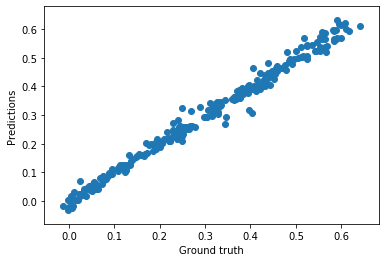

In [28]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [40]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               #X_motion_RL_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.481010384046785
RMSE:  0.007717307555831835
The lowest error is:  1.6218610375540177e-05
The highest error is:  0.04303856345748333
The avg. error is:  0.0058271656719103455


In [41]:
model_rl_relative_swinging_y.coef_

array([[ 2.57320771e-03, -1.35308431e-16, -6.09321621e-17,
         6.59747348e-03,  2.22044605e-16,  0.00000000e+00,
        -7.98642419e-02,  3.73805608e-01,  1.69780011e-01,
        -7.97532303e-02,  5.46915760e-03, -1.79611612e+00,
         1.47892327e-01,  3.34829672e-01]])

In [42]:
model_rl_relative_swinging_y.intercept_

array([0.2355151])

Text(0, 0.5, 'Predictions')

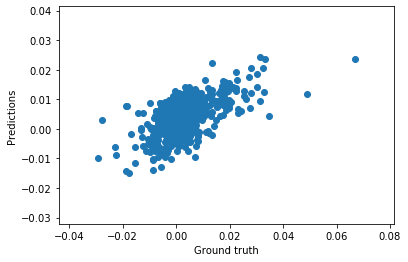

In [32]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [33]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')